In [15]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score


import pandas as pd
import numpy as np
import ast

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score
from sklearn.compose import TransformedTargetRegressor


In [16]:
# Compute mu and sigma using only participating clients
def compute_mu_sigma(row):
    active_clients = ast.literal_eval(row["Clients"])
    selected_cols = [f"Client {i} Accuracy" for i in active_clients]
    accuracies = row[selected_cols].values
    return pd.Series({
        "mu": np.mean(accuracies),
        "sigma": np.std(accuracies)
    })

In [28]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
import numpy as np

def _logit(y):
    y = np.clip(y, 1e-6, 1 - 1e-6)
    return np.log(y / (1 - y))

def _logistic(z):
    return 1 / (1 + np.exp(-z))

def evaluate_models(X, y,
                    poly_degree=2,
                    nn_hidden_layer_sizes=(10,),
                    nn_max_iter=10000,
                    nn_random_state=0):
    results = {}

    # 1) Linear Regression with logit link
    base_lin = LinearRegression()
    lin = TransformedTargetRegressor(
        regressor=base_lin,
        func=_logit,
        inverse_func=_logistic
    )
    lin.fit(X, y)
    y_lin_pred = lin.predict(X)
    lin_r2 = r2_score(y, y_lin_pred)

    # **extract** the inner coefs/intercept
    coef_lin = lin.regressor_.coef_
    icpt_lin = lin.regressor_.intercept_

    print("Linear Model (with logit link):")
    print(f"  A_g = logistic({coef_lin[0]:.4f}·μ + {coef_lin[1]:.4f}·σ + {icpt_lin:.4f})")
    print(f"  R² Score: {lin_r2:.4f}\n")

    results['linear'] = {
        'model': lin,
        'r2': lin_r2,
        'y_pred': y_lin_pred,
        'coef_': coef_lin,
        'intercept': icpt_lin
    }

     # 2) Polynomial Regression with logit link
    poly_base = make_pipeline(
        PolynomialFeatures(degree=poly_degree),
        StandardScaler(),
        LinearRegression()
    )
    poly = TransformedTargetRegressor(
        regressor=poly_base,
        func=_logit,
        inverse_func=_logistic
    )
    poly.fit(X, y)
    y_poly_pred = poly.predict(X)
    poly_r2 = r2_score(y, y_poly_pred)

    # **Fixed**: grab the inner linear layer & feature‐names without assuming DataFrame columns
    pf = poly.regressor_.named_steps['polynomialfeatures']
    linreg = poly.regressor_.named_steps['linearregression']
    feat_names = pf.get_feature_names_out()  # e.g. ['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2']
    # map 'x0'→'μ', 'x1'→'σ'
    pretty = [name.replace('x0', 'μ').replace('x1', 'σ') for name in feat_names]

    coefs = dict(zip(pretty, linreg.coef_))
    intercept_poly = linreg.intercept_

    print(f"Polynomial Model (Degree {poly_degree}, logit link):")
    print(f"  R² Score: {poly_r2:.4f}\n")

    results['polynomial'] = {
        'model': poly,
        'r2': poly_r2,
        'y_pred': y_poly_pred,
        'coefficients': coefs,
        'intercept': intercept_poly
    }

       # 3) Neural Network Regression with logit link
    nn_base = make_pipeline(
        StandardScaler(),
        MLPRegressor(
            hidden_layer_sizes=nn_hidden_layer_sizes,
            max_iter=nn_max_iter,
            random_state=nn_random_state,
            early_stopping=True,
            verbose=False
        )
    )
    nn = TransformedTargetRegressor(
        regressor=nn_base,
        func=_logit,
        inverse_func=_logistic
    )
    nn.fit(X, y)
    y_nn_pred = nn.predict(X)
    nn_r2 = r2_score(y, y_nn_pred)

    print("Neural Network Model (with logit link):")
    print(f"  Hidden layers: {nn_hidden_layer_sizes}, max_iter: {nn_max_iter}")
    print(f"  R² Score: {nn_r2:.4f}\n")

    results['neural_net'] = dict(model=nn, r2=nn_r2, y_pred=y_nn_pred)

    return results

def markdown_equations(results):
    # Linear
    c_mu, c_sigma = results['linear']['coef_']
    icpt_lin = results['linear']['intercept']

    md = []
    md.append("### Linear Model\n")
    md.append("$$")
    md.append(f"A_g = {c_mu:.4f}\\,\\mu + {c_sigma:.4f}\\,\\sigma + {icpt_lin:.4f}")
    md.append("$$\n---\n")

    # Polynomial
    coefs = results['polynomial']['coefficients']
    b0 = results['polynomial']['intercept']

    # build expression term by term
    terms = [f"{b0:.4f}"]
    for var in ["μ", "σ", "μ^2", "μ σ", "σ^2"]:
        terms.append(f"{coefs.get(var, 0):+.4f}\\,{var}")

    expr = " ".join(terms)

    md.append("### Polynomial Model\n")
    md.append("$$")
    md.append(f"A_g = {expr}")
    md.append("$$")

    return "\n".join(md)

In [ ]:
#chat
def evaluate_models(X, y,
                    poly_degree=2,
                    nn_hidden_layer_sizes=(10,),
                    nn_max_iter=10000,
                    nn_random_state=0):
    # -- helper transforms
    def _logit(u):
        # avoid extremes exactly at 0 or 1
        u = np.clip(u, 1e-6, 1 - 1e-6)
        return np.log(u / (1 - u))
    def _sigmoid(z):
        return 1 / (1 + np.exp(-z))

    results = {}

    # 1) Linear Regression with logit link
    lin_ttr = TransformedTargetRegressor(
        regressor=LinearRegression(),
        func=_logit,
        inverse_func=_sigmoid
    )
    lin_ttr.fit(X, y)
    y_lin_pred = lin_ttr.predict(X)  # guaranteed in (0,1)
    lin_r2 = r2_score(y, y_lin_pred)
    w1, w2 = lin_ttr.regressor_.coef_
    b = lin_ttr.regressor_.intercept_
    eq_lin = (
        "A_g = 1/(1+exp(-("
        f"{w1:.4f}*mu + {w2:.4f}*sigma + {b:.4f}"
        ")))"
    )
    print("Linear Model (with logit–sigmoid):")
    print(" ", eq_lin)
    print(f"  R² Score: {lin_r2:.4f}\n")
    results['linear'] = {
        'model': lin_ttr,
        'r2': lin_r2,
        'equation': eq_lin,
        'y_pred': y_lin_pred
    }

    # 2) Polynomial Regression with logit link
    poly_pipe = make_pipeline(
        PolynomialFeatures(degree=poly_degree),
        LinearRegression()
    )
    poly_ttr = TransformedTargetRegressor(
        regressor=poly_pipe,
        func=_logit,
        inverse_func=_sigmoid
    )
    poly_ttr.fit(X, y)
    y_poly_pred = poly_ttr.predict(X)
    poly_r2 = r2_score(y, y_poly_pred)

    coefs = poly_ttr.regressor_.named_steps['linearregression'].coef_
    feats = poly_ttr.regressor_.named_steps['polynomialfeatures'].get_feature_names_out(['mu','sigma'])
    print(f"Polynomial Model (Degree {poly_degree}, logit–sigmoid):")
    print("  Inner linear terms (before sigmoid):")
    for feat, coef in zip(feats, coefs):
        if abs(coef) > 1e-8:
            print(f"    {coef:.4f} * {feat}")
    b_poly = poly_ttr.regressor_.named_steps['linearregression'].intercept_
    print(f"  Intercept: {b_poly:.4f}")
    print(f"  R² Score: {poly_r2:.4f}\n")

    results['polynomial'] = {
        'model': poly_ttr,
        'r2': poly_r2,
        'coefficients': dict(zip(feats, coefs)),
        'intercept': b_poly,
        'y_pred': y_poly_pred
    }

    # 3) Neural Network Regression with logit link
    nn_base = MLPRegressor(
        hidden_layer_sizes=nn_hidden_layer_sizes,
        max_iter=nn_max_iter,
        random_state=nn_random_state
    )
    nn_ttr = TransformedTargetRegressor(
        regressor=nn_base,
        func=_logit,
        inverse_func=_sigmoid
    )
    nn_ttr.fit(X, y)
    y_nn_pred = nn_ttr.predict(X)
    nn_r2 = r2_score(y, y_nn_pred)
    print("Neural Network Model (with logit–sigmoid):")
    print(f"  Hidden layers: {nn_hidden_layer_sizes}, max_iter: {nn_max_iter}")
    print(f"  R² Score: {nn_r2:.4f}\n")

    results['neural_net'] = {
        'model': nn_ttr,
        'r2': nn_r2,
        'y_pred': y_nn_pred
    }

    return results


In [3]:
def evaluate_models(X, y,
                    poly_degree=2,
                    nn_hidden_layer_sizes=(10,),
                    nn_max_iter=10000,
                    nn_random_state=0):
    results = {}
    
    # 1) Linear Regression
    lin = LinearRegression()
    lin.fit(X, y)
    y_lin_pred = lin.predict(X)
    lin_r2 = r2_score(y, y_lin_pred)
    eq_lin = f"A_g = {lin.coef_[0]:.4f} * mu + {lin.coef_[1]:.4f} * sigma + {lin.intercept_:.4f}"
    print("Linear Model:")
    print(" ", eq_lin)
    print(f"  R² Score: {lin_r2:.4f}\n")
    results['linear'] = {
        'model': lin,
        'r2': lin_r2,
        'equation': eq_lin,
        'y_pred': y_lin_pred
    }
    
    # 2) Polynomial Regression
    poly = make_pipeline(PolynomialFeatures(degree=poly_degree), LinearRegression())
    poly.fit(X, y)
    y_poly_pred = poly.predict(X)
    poly_r2 = r2_score(y, y_poly_pred)
    coefs = poly.named_steps['linearregression'].coef_
    feats = poly.named_steps['polynomialfeatures'].get_feature_names_out(['mu','sigma'])
    print(f"Polynomial Model (Degree {poly_degree}):")
    for feat, coef in zip(feats, coefs):
        if abs(coef) > 1e-8:
            print(f"  {coef:.4f} * {feat}")
    print(f"  R² Score: {poly_r2:.4f}\n")
    results['polynomial'] = {
        'model': poly,
        'r2': poly_r2,
        'coefficients': dict(zip(feats, coefs)),
        'y_pred': y_poly_pred
    }
    
    # 3) Neural Network (MLP) Regression
    nn = MLPRegressor(hidden_layer_sizes=nn_hidden_layer_sizes,
                      max_iter=nn_max_iter,
                      random_state=nn_random_state)
    nn.fit(X, y)
    y_nn_pred = nn.predict(X)
    nn_r2 = r2_score(y, y_nn_pred)
    print("Neural Network Model:")
    print(f"  Hidden layers: {nn_hidden_layer_sizes}, max_iter: {nn_max_iter}")
    print(f"  R² Score: {nn_r2:.4f}\n")
    results['neural_net'] = {
        'model': nn,
        'r2': nn_r2,
        'y_pred': y_nn_pred
    }
    
    return results


In [4]:
def plot_model_predictions(
    y,
    linear_pred,
    poly_pred,
    nn_pred,
    linear_r2,
    poly_r2,
    nn_r2,
    title="Model Comparison",
    figsize=(15, 5)
):
    plt.figure(figsize=figsize)
    plt.suptitle(title, fontsize=16)
    lo, hi = y.min(), y.max()
    ax1 = plt.subplot(1, 3, 1)
    ax1.scatter(y, linear_pred, alpha=0.6)
    ax1.plot([lo, hi], [lo, hi], 'r--')
    ax1.set_xlabel("True Global Accuracy")
    ax1.set_ylabel("Predicted")
    ax1.set_title(f"Linear (R² = {linear_r2:.2f})")
    ax2 = plt.subplot(1, 3, 2)
    ax2.scatter(y, poly_pred, alpha=0.6)
    ax2.plot([lo, hi], [lo, hi], 'r--')
    ax2.set_xlabel("True Global Accuracy")
    ax2.set_title(f"Polynomial (R² = {poly_r2:.2f})")
    ax3 = plt.subplot(1, 3, 3)
    ax3.scatter(y, nn_pred, alpha=0.6)
    ax3.plot([lo, hi], [lo, hi], 'r--')
    ax3.set_xlabel("True Global Accuracy")
    ax3.set_title(f"Neural Net (R² = {nn_r2:.2f})")

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


In [5]:
def results_to_markdown(results, overall_title=None):
    lines = []
    if overall_title:
        lines.append(f"# {overall_title}\n")

    # --- Linear Model ---
    lin = results['linear']['model']
    c0, c1 = lin.coef_
    b = lin.intercept_
    lines.append("### Linear Model\n")
    lines.append("$$")
    lines.append(f"A_g = {c0:.4f}\\cdot\\mu + {c1:.4f}\\cdot\\sigma + {b:.4f}")
    lines.append("$$\n")
    lines.append(f"**R² Score:** {results['linear']['r2']:.4f}\n")
    lines.append("---\n")

    # --- Polynomial Model ---
    poly_coefs = results['polynomial']['coefficients']
    # drop the bias term if present
    poly_items = [(feat, coef) 
                  for feat, coef in poly_coefs.items() 
                  if feat != "1" and abs(coef) > 1e-8]

    # build each term: e.g. mu^2 → coeff·μ^2; "mu sigma" → coeff·μ·σ
    term_strs = []
    for feat, coef in poly_items:
        # convert feature name to LaTeX
        latex_feat = feat.replace("mu", "\\mu").replace("sigma", "\\sigma") \
                         .replace(" ", "\\cdot")
        term_strs.append(f"{coef:.4f}\\cdot{latex_feat}")

    # you can optionally group second-degree terms, but here we'll just join
    eq_poly = " + ".join(term_strs)
    # clean up + - signs
    eq_poly = eq_poly.replace("+ -", "- ")

    lines.append("### Polynomial Model\n")
    lines.append("$$")
    lines.append(f"A_g = {eq_poly}")
    lines.append("$$\n")
    lines.append(f"**R² Score:** {results['polynomial']['r2']:.4f}\n")
    lines.append("---\n")

    # --- Neural Net ---
    lines.append("### Neural Network Model\n")
    lines.append(f"**Architecture:** {results['neural_net']['model'].hidden_layer_sizes}, "
                 f"max_iter={results['neural_net']['model'].max_iter}\n")
    lines.append(f"**R² Score:** {results['neural_net']['r2']:.4f}\n")

    return "\n".join(lines)


In [6]:
def markdown_equations(results):
    # Linear coefficients
    lin = results['linear']['model']
    c_mu, c_sigma = lin.coef_
    intercept = lin.intercept_

    # Polynomial coefficients
    poly_coefs = results['polynomial']['coefficients']
    # extract and remove squared terms
    a_mu2 = poly_coefs.pop('mu^2', 0)
    a_sigma2 = poly_coefs.pop('sigma^2', 0)
    # the remaining terms: mu, sigma, mu sigma
    a_mu = poly_coefs.get('mu', 0)
    a_sigma = poly_coefs.get('sigma', 0)
    a_mu_sigma = poly_coefs.get('mu sigma', 0)

    # Build the Markdown
    md_lines = []

    # Linear model
    md_lines.append("###  Linear Model \n")
    md_lines.append("$$")
    md_lines.append(f"A_g = {c_mu:.4f} \\cdot \\mu + {c_sigma:.4f} \\cdot \\sigma + {intercept:.4f}")
    md_lines.append("$$\n")
    md_lines.append("---\n")

    # Polynomial model
    md_lines.append("###  Polynomial Model \n")
    md_lines.append("$$")
    # group squared terms with a leading minus
    md_lines.append(
        f"A_g =  - ("
        f"{abs(a_mu2):.4f} \\cdot \\mu^2 +  {abs(a_sigma2):.4f} \\cdot \\sigma^2 )"
        f" + {a_mu:.4f} \\cdot \\mu"
        f" + {a_sigma:.4f} \\cdot \\sigma"
        f" + {a_mu_sigma:.4f} \\cdot \\mu \\cdot \\sigma "
    )
    md_lines.append("$$")

    return "\n".join(md_lines)

### Spambase _ FedLR

In [7]:
# Load the CSV
df = pd.read_csv("/Users/abbaszal/Documents/Thesis_Project_Spambase/results/FedLR_Spambase_without_LQC/Spambase_results_with_LR.csv") 
df[["mu", "sigma"]] = df.apply(compute_mu_sigma, axis=1)
X = df[["mu", "sigma"]].values
y = df["Global Accuracy"].values

In [ ]:
results = evaluate_models(X, y, poly_degree=2, nn_hidden_layer_sizes=(10,), nn_max_iter=10000)

Linear Model:
  A_g = 0.9155 * mu + 0.2116 * sigma + 0.0973
  R² Score: 0.3395

Polynomial Model (Degree 2):
  93.4143 * mu
  0.9371 * sigma
  -51.7189 * mu^2
  2.2168 * mu sigma
  -151.8281 * sigma^2
  R² Score: 0.5308

Neural Network Model:
  Hidden layers: (10,), max_iter: 10000
  R² Score: 0.3306



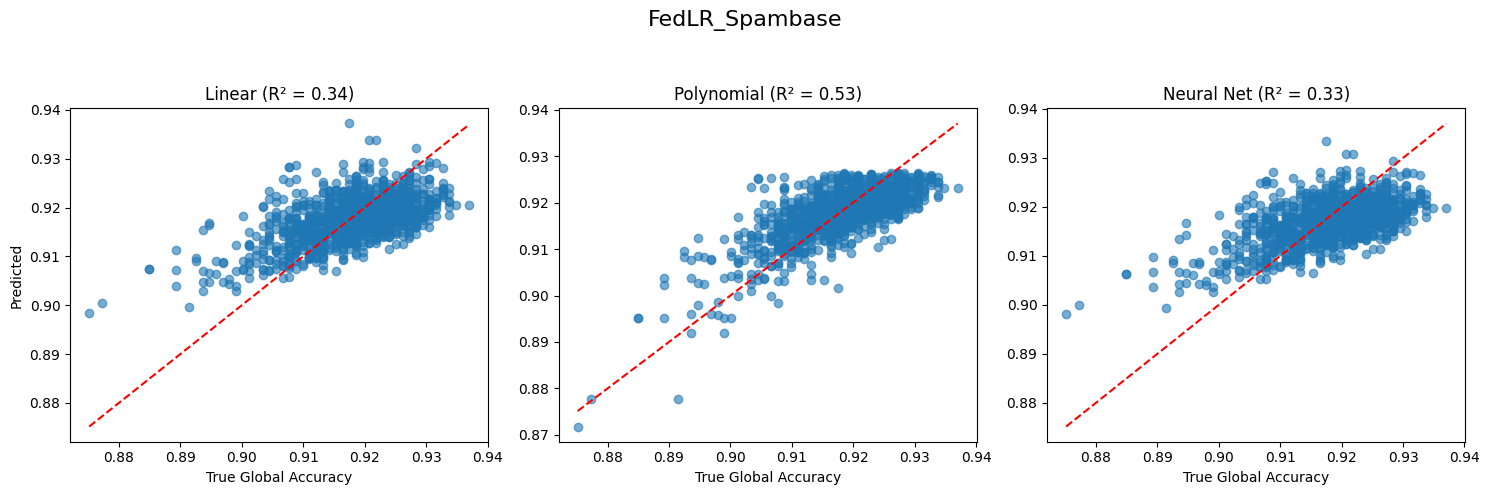

In [ ]:
plot_model_predictions(
    y,
    results['linear']['y_pred'],
    results['polynomial']['y_pred'],
    results['neural_net']['y_pred'],
    results['linear']['r2'],
    results['polynomial']['r2'],
    results['neural_net']['r2'],
    title="FedLR_Spambase"
)

In [29]:
results = evaluate_models(X, y, poly_degree=2, nn_hidden_layer_sizes=(10,), nn_max_iter=10000)

Linear Model (with logit link):
  A_g = logistic(11.8633·μ + 2.0471·σ + -8.2069)
  R² Score: 0.3511

Polynomial Model (Degree 2, logit link):
  R² Score: 0.5270

Neural Network Model (with logit link):
  Hidden layers: (10,), max_iter: 10000
  R² Score: 0.4271



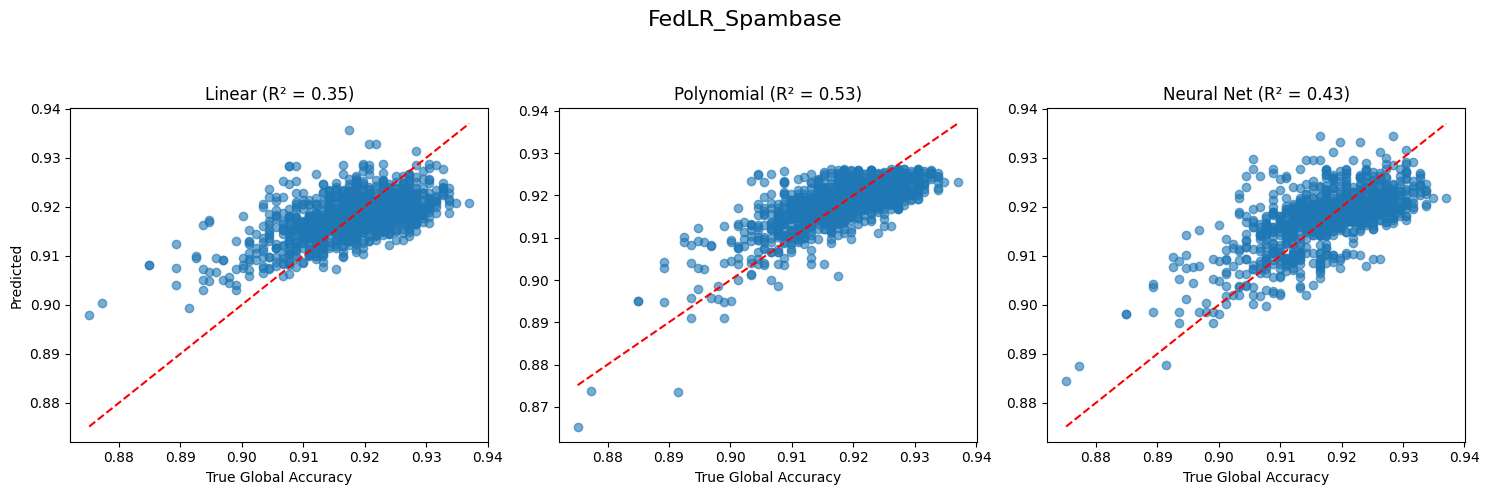

In [31]:
plot_model_predictions(
    y,
    results['linear']['y_pred'],
    results['polynomial']['y_pred'],
    results['neural_net']['y_pred'],
    results['linear']['r2'],
    results['polynomial']['r2'],
    results['neural_net']['r2'],
    title="FedLR_Spambase"
)

In [30]:
print(markdown_equations(results))

### Linear Model

$$
A_g = 11.8633\,\mu + 2.0471\,\sigma + -8.2069
$$
---

### Polynomial Model

$$
A_g = 2.4142 +5.7277\,μ -0.3064\,σ -5.6701\,μ^2 +0.4318\,μ σ -0.1362\,σ^2
$$


In [ ]:
#print(markdown_equations(results))

###  Linear Model 

$$
A_g = 0.9155 \cdot \mu + 0.2116 \cdot \sigma + 0.0973
$$

---

###  Polynomial Model 

$$
A_g =  - (51.7189 \cdot \mu^2 +  151.8281 \cdot \sigma^2 ) + 93.4143 \cdot \mu + 0.9371 \cdot \sigma + 2.2168 \cdot \mu \cdot \sigma 
$$

### HuGaDB _ FedLR

In [10]:
# Load the CSV
df = pd.read_csv("/Users/abbaszal/Documents/Fit/hugadb_fedlr/HuGaDB_results_with_LR.csv") 
df[["mu", "sigma"]] = df.apply(compute_mu_sigma, axis=1)

# 2. Split out Trial 1 for fitting
df_train = df[df["Trial"] == 1]
X = df_train[["mu", "sigma"]].values
y = df_train["Global Accuracy"].values

In [ ]:
results = evaluate_models(X, y, poly_degree=2, nn_hidden_layer_sizes=(10,), nn_max_iter=10000)

Linear Model:
  A_g = 1.2319 * mu + 0.8786 * sigma + -0.0920
  R² Score: 0.5034

Polynomial Model (Degree 2):
  10.5064 * mu
  -3.3921 * sigma
  -9.0257 * mu^2
  8.6726 * mu sigma
  -10.3723 * sigma^2
  R² Score: 0.6300

Neural Network Model:
  Hidden layers: (10,), max_iter: 10000
  R² Score: 0.4233



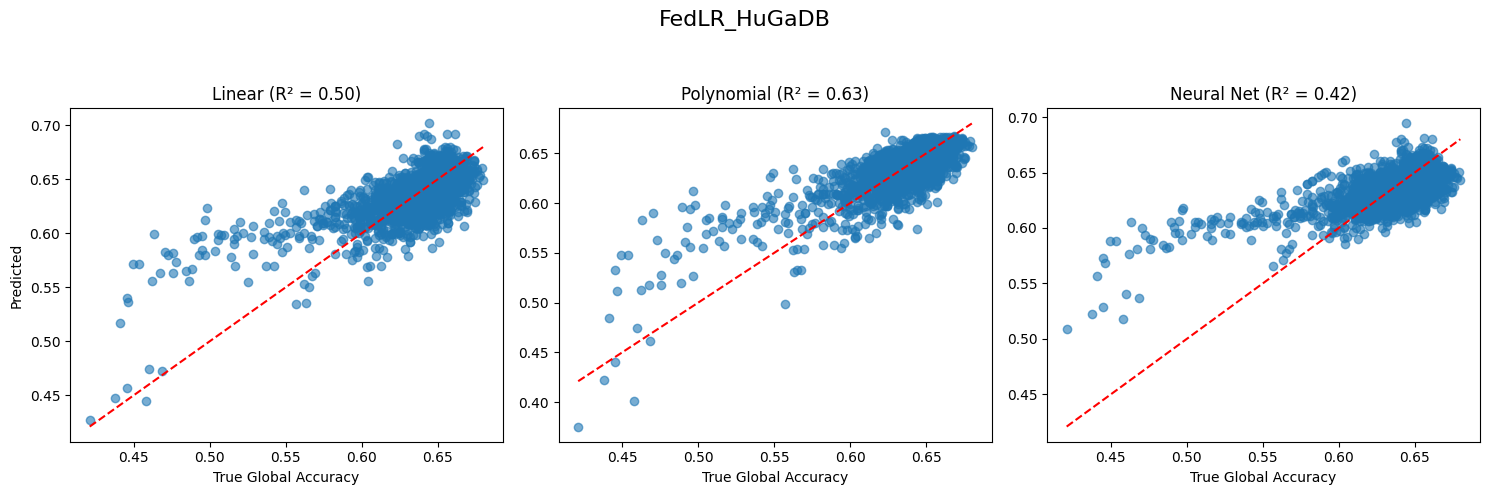

In [14]:
plot_model_predictions(
    y,
    results['linear']['y_pred'],
    results['polynomial']['y_pred'],
    results['neural_net']['y_pred'],
    results['linear']['r2'],
    results['polynomial']['r2'],
    results['neural_net']['r2'],
    title="FedLR_HuGaDB"
)

In [ ]:
#print(markdown_equations(results))

###  Linear Model 

$$
A_g = 1.2319 \cdot \mu + 0.8786 \cdot \sigma + -0.0920
$$

---

###  Polynomial Model 

$$
A_g =  - (9.0257 \cdot \mu^2 +  10.3723 \cdot \sigma^2 ) + 10.5064 \cdot \mu + -3.3921 \cdot \sigma + 8.6726 \cdot \mu \cdot \sigma 
$$

### Spambase _ FedFor

In [15]:
# Load the CSV
df = pd.read_csv("/Users/abbaszal/Documents/Thesis_Project_Spambase/results/FedFor_Spambase_without_LQC/Spambase_results_with_FedFor.csv") 
df[["mu", "sigma"]] = df.apply(compute_mu_sigma, axis=1)
X = df[["mu", "sigma"]].values
y = df["Global Accuracy"].values

In [16]:
results = evaluate_models(X, y, poly_degree=2, nn_hidden_layer_sizes=(10,), nn_max_iter=10000)

Linear Model:
  A_g = 0.5991 * mu + 2.7232 * sigma + 0.3635
  R² Score: 0.2333

Polynomial Model (Degree 2):
  74.8613 * mu
  74.0857 * sigma
  -42.8163 * mu^2
  -74.5616 * mu sigma
  -506.1317 * sigma^2
  R² Score: 0.3542

Neural Network Model:
  Hidden layers: (10,), max_iter: 10000
  R² Score: 0.0557



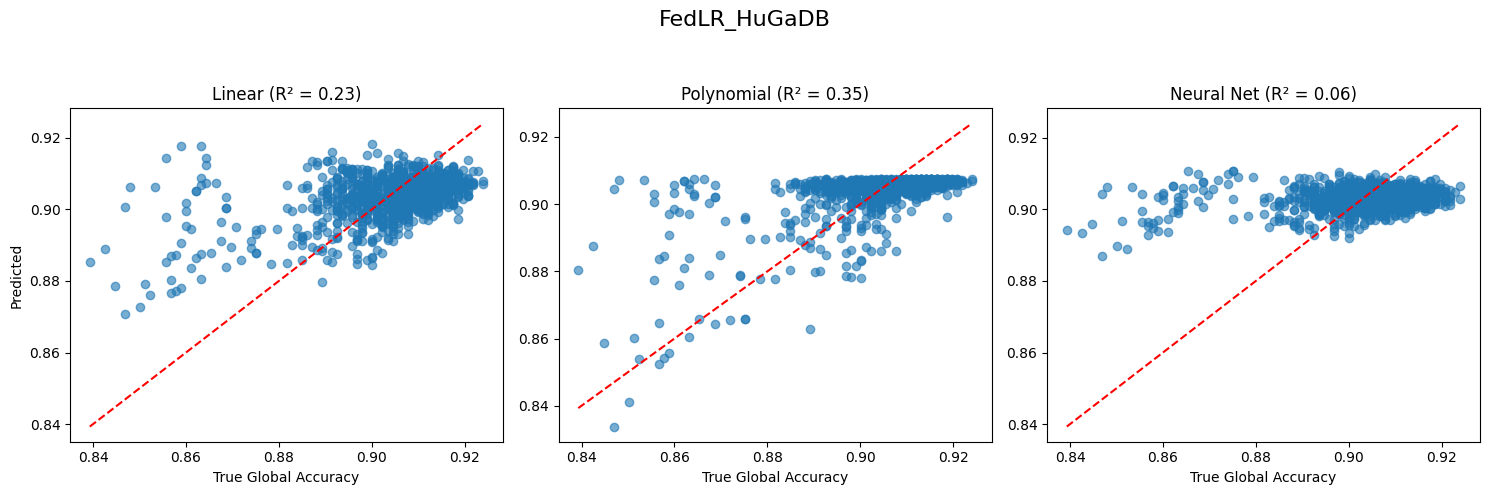

In [17]:
plot_model_predictions(
    y,
    results['linear']['y_pred'],
    results['polynomial']['y_pred'],
    results['neural_net']['y_pred'],
    results['linear']['r2'],
    results['polynomial']['r2'],
    results['neural_net']['r2'],
    title="FedLR_HuGaDB"
)

In [ ]:
#print(markdown_equations(results))

###  Linear Model 

$$
A_g = 0.5991 \cdot \mu + 2.7232 \cdot \sigma + 0.3635
$$

---

###  Polynomial Model 

$$
A_g =  - (42.8163 \cdot \mu^2 +  506.1317 \cdot \sigma^2 ) + 74.8613 \cdot \mu + 74.0857 \cdot \sigma + -74.5616 \cdot \mu \cdot \sigma 
$$

### HuGaDB _ FedFor

In [19]:
# Load the CSV
df = pd.read_csv("/Users/abbaszal/Documents/Fit/hugadb_fedfor/HuGaDB_results_with_FedFor.csv") 
df[["mu", "sigma"]] = df.apply(compute_mu_sigma, axis=1)
df_train = df[df["Trial"] == 1]
X = df_train[["mu", "sigma"]].values
y = df_train["Global Accuracy"].values

In [20]:
results = evaluate_models(X, y, poly_degree=2, nn_hidden_layer_sizes=(10,), nn_max_iter=10000)

Linear Model:
  A_g = 1.1339 * mu + 1.4987 * sigma + -0.0349
  R² Score: 0.5748

Polynomial Model (Degree 2):
  4.0939 * mu
  6.8170 * sigma
  -2.6359 * mu^2
  -3.6142 * mu sigma
  -29.8439 * sigma^2
  R² Score: 0.6299

Neural Network Model:
  Hidden layers: (10,), max_iter: 10000
  R² Score: 0.5027



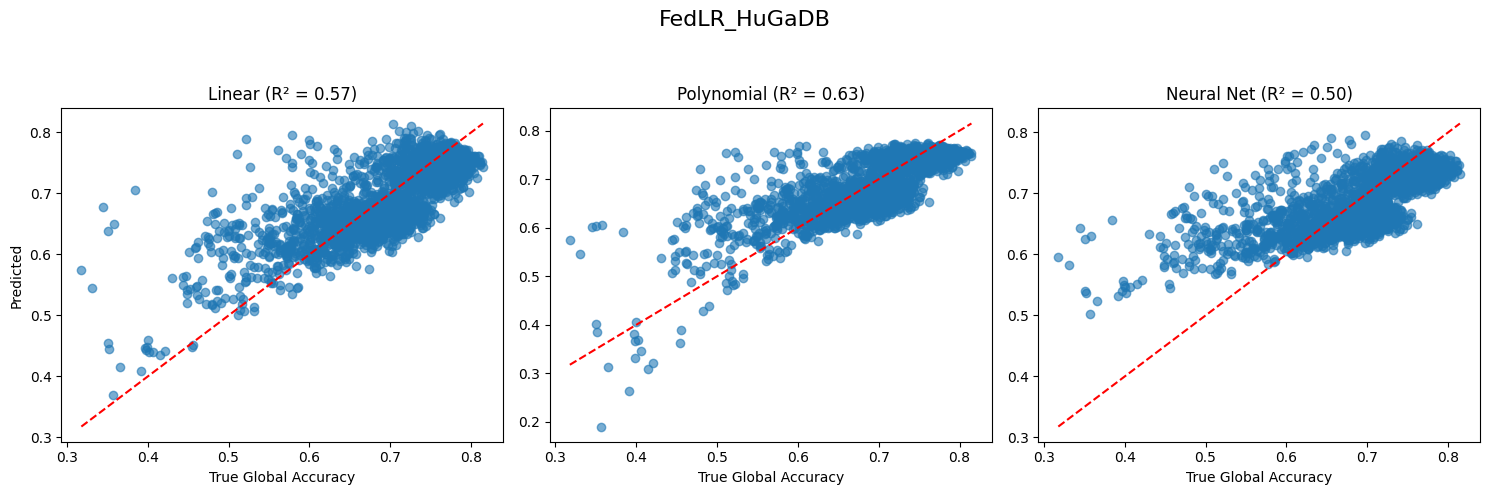

In [21]:
plot_model_predictions(
    y,
    results['linear']['y_pred'],
    results['polynomial']['y_pred'],
    results['neural_net']['y_pred'],
    results['linear']['r2'],
    results['polynomial']['r2'],
    results['neural_net']['r2'],
    title="FedLR_HuGaDB"
)

In [ ]:
#print(markdown_equations(results))

###  Linear Model 

$$
A_g = 1.1339 \cdot \mu + 1.4987 \cdot \sigma + -0.0349
$$

---

###  Polynomial Model 

$$
A_g =  - (2.6359 \cdot \mu^2 +  29.8439 \cdot \sigma^2 ) + 4.0939 \cdot \mu + 6.8170 \cdot \sigma + -3.6142 \cdot \mu \cdot \sigma 
$$

### Accelerometer _ FedLR

In [23]:
# Load the CSV
df = pd.read_csv("/Users/abbaszal/Documents/Fit/accelerometer_fedlr/accelerometer_10_LR_results.csv") 
df[["mu", "sigma"]] = df.apply(compute_mu_sigma, axis=1)
df_train = df[df["Trial"] == 1]
X = df_train[["mu", "sigma"]].values
y = df_train["Global Accuracy"].values

In [24]:
results = evaluate_models(X, y, poly_degree=2, nn_hidden_layer_sizes=(10,), nn_max_iter=10000)

Linear Model:
  A_g = 1.8379 * mu + -0.1511 * sigma + -0.2778
  R² Score: 0.4206

Polynomial Model (Degree 2):
  0.9806 * mu
  -1.7386 * sigma
  1.1417 * mu^2
  6.0352 * mu sigma
  -9.9846 * sigma^2
  R² Score: 0.4215

Neural Network Model:
  Hidden layers: (10,), max_iter: 10000
  R² Score: 0.2828



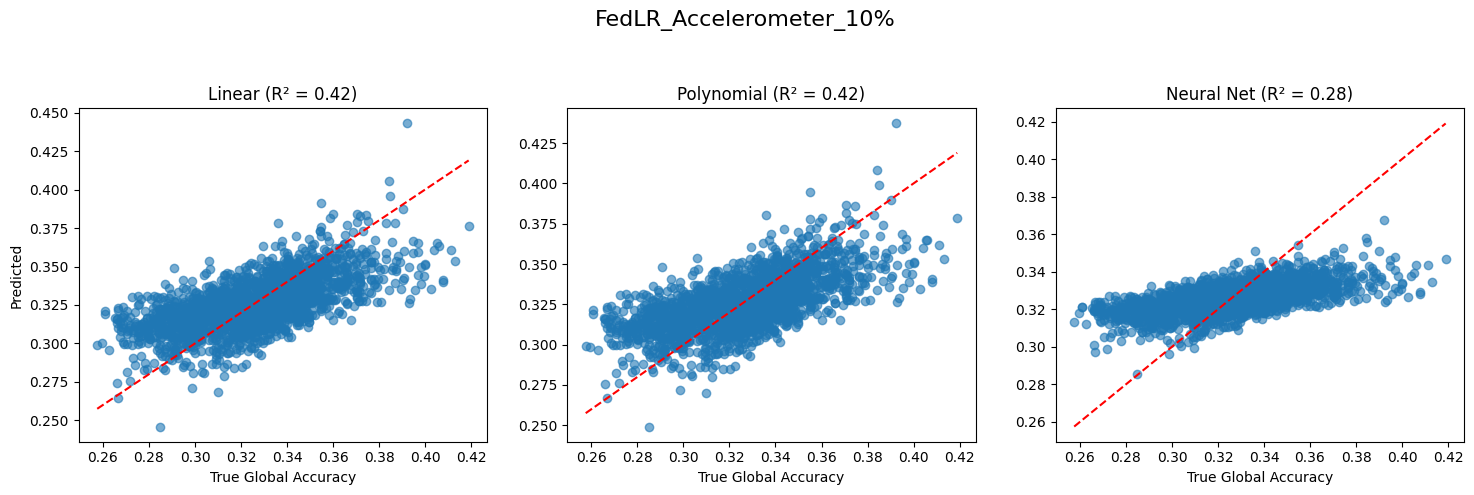

In [28]:
plot_model_predictions(
    y,
    results['linear']['y_pred'],
    results['polynomial']['y_pred'],
    results['neural_net']['y_pred'],
    results['linear']['r2'],
    results['polynomial']['r2'],
    results['neural_net']['r2'],
    title="FedLR_Accelerometer_10%"
)

In [ ]:
#print(markdown_equations(results))

###  Linear Model 

$$
A_g = 1.8379 \cdot \mu + -0.1511 \cdot \sigma + -0.2778
$$

---

###  Polynomial Model 

$$
A_g =  - (1.1417 \cdot \mu^2 +  9.9846 \cdot \sigma^2 ) + 0.9806 \cdot \mu + -1.7386 \cdot \sigma + 6.0352 \cdot \mu \cdot \sigma 
$$

In [60]:
# Load the CSV
df = pd.read_csv("/Users/abbaszal/Documents/Fit/accelerometer_fedlr/accelerometer_100_LR_results.csv") 
df[["mu", "sigma"]] = df.apply(compute_mu_sigma, axis=1)
df_train = df[df["Trial"] == 1]
X = df_train[["mu", "sigma"]].values
y = df_train["Global Accuracy"].values

In [61]:
results = evaluate_models(X, y, poly_degree=2, nn_hidden_layer_sizes=(10,), nn_max_iter=10000)

Linear Model:
  A_g = 0.9585 * mu + -0.2938 * sigma + 0.0120
  R² Score: 0.4052

Polynomial Model (Degree 2):
  -10.4268 * mu
  2.4754 * sigma
  18.7890 * mu^2
  -7.1538 * mu sigma
  -11.2157 * sigma^2
  R² Score: 0.4172

Neural Network Model:
  Hidden layers: (10,), max_iter: 10000
  R² Score: 0.3133



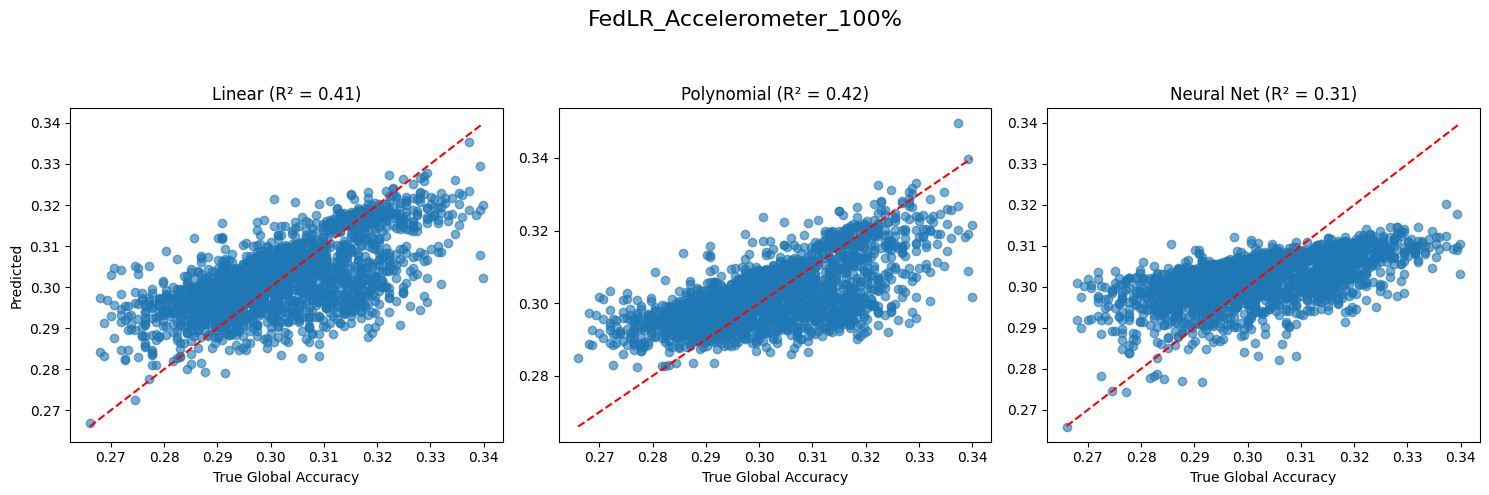

In [64]:
plot_model_predictions(
    y,
    results['linear']['y_pred'],
    results['polynomial']['y_pred'],
    results['neural_net']['y_pred'],
    results['linear']['r2'],
    results['polynomial']['r2'],
    results['neural_net']['r2'],
    title="FedLR_Accelerometer_100%"
)

In [ ]:
#print(markdown_equations(results))

###  Linear Model 

$$
A_g = 0.9585 \cdot \mu + -0.2938 \cdot \sigma + 0.0120
$$

---

###  Polynomial Model 

$$
A_g =  - (18.7890 \cdot \mu^2 +  11.2157 \cdot \sigma^2 ) + -10.4268 \cdot \mu + 2.4754 \cdot \sigma + -7.1538 \cdot \mu \cdot \sigma 
$$

### Accelerometer _ FedFor

In [66]:
# Load the CSV
df = pd.read_csv("/Users/abbaszal/Documents/Fit/accelerometer_fedfor/accelerometer_10_FedFor_results.csv") 
df[["mu", "sigma"]] = df.apply(compute_mu_sigma, axis=1)
df_train = df[df["Trial"] == 1]
X = df_train[["mu", "sigma"]].values
y = df_train["Global Accuracy"].values

In [67]:
results = evaluate_models(X, y, poly_degree=2, nn_hidden_layer_sizes=(10,), nn_max_iter=10000)

Linear Model (with logit–sigmoid):
  A_g = 1/(1+exp(-(4.3741*mu + 2.4014*sigma + -2.1137)))
  R² Score: 0.5893

Polynomial Model (Degree 2, logit–sigmoid):
  Inner linear terms (before sigmoid):
    58.3304 * mu
    -1.1567 * sigma
    -58.7497 * mu^2
    32.5270 * mu sigma
    -306.6804 * sigma^2
  Intercept: -14.5678
  R² Score: 0.6693

Neural Network Model (with logit–sigmoid):
  Hidden layers: (10,), max_iter: 10000
  R² Score: 0.1328



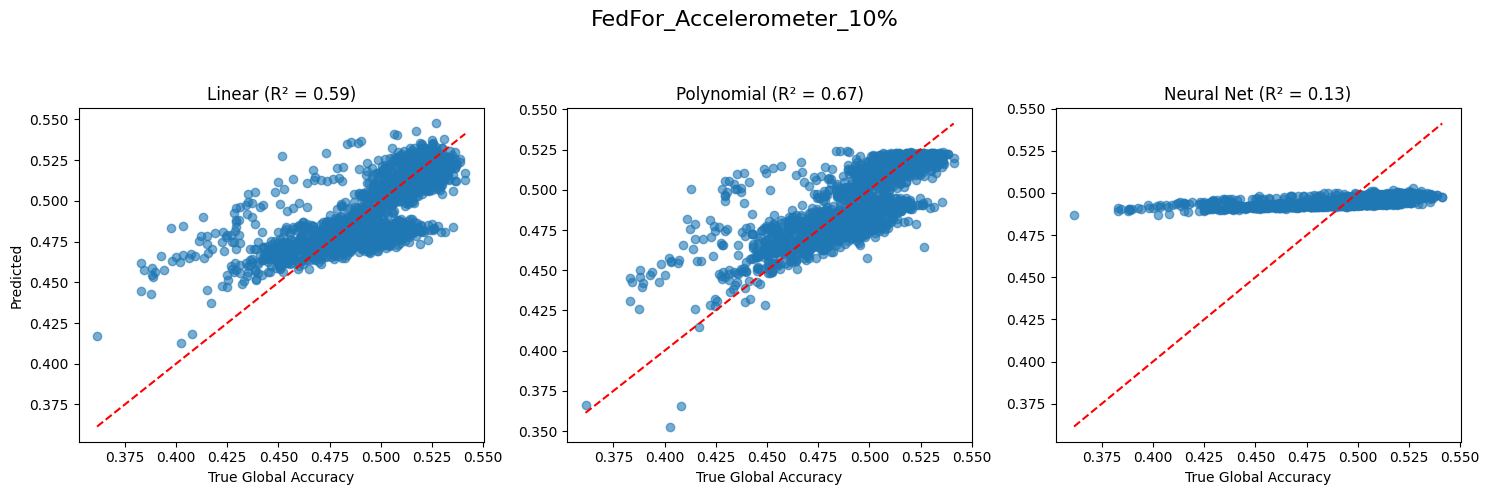

In [68]:
plot_model_predictions(
    y,
    results['linear']['y_pred'],
    results['polynomial']['y_pred'],
    results['neural_net']['y_pred'],
    results['linear']['r2'],
    results['polynomial']['r2'],
    results['neural_net']['r2'],
    title="FedFor_Accelerometer_10%"
)

In [70]:
def markdown_equations(results):
    # --- Linear model (unwrap TTR)
    lin_ttr = results['linear']['model']
    lin = lin_ttr.regressor_  # the fitted LinearRegression inside the TTR
    c_mu, c_sigma = lin.coef_
    intercept = lin.intercept_

    # --- Polynomial model
    # coefficients dict and intercept were saved in results
    poly_coefs = results['polynomial']['coefficients'].copy()
    poly_intercept = results['polynomial']['intercept']

    # pull out squared terms (or 0 if absent)
    a_mu2    = poly_coefs.pop('mu^2',      0)
    a_sigma2 = poly_coefs.pop('sigma^2',   0)
    # remaining terms: 'mu', 'sigma', 'mu sigma'
    a_mu        = poly_coefs.get('mu',       0)
    a_sigma     = poly_coefs.get('sigma',    0)
    a_mu_sigma  = poly_coefs.get('mu sigma', 0)

    # --- Build Markdown
    md_lines = []

    # Linear
    md_lines.append("### Linear Model\n")
    md_lines.append("$$")
    md_lines.append(
        f"A_g = {c_mu:.4f}\\,\\mu + {c_sigma:.4f}\\,\\sigma + {intercept:.4f}"
    )
    md_lines.append("$$\n")
    md_lines.append("---\n")

    # Polynomial
    md_lines.append("### Polynomial Model\n")
    md_lines.append("$$")
    terms = []
    if abs(a_mu2)    > 1e-8: terms.append(f"{a_mu2:.4f}\\,\\mu^2")
    if abs(a_sigma2) > 1e-8: terms.append(f"{a_sigma2:.4f}\\,\\sigma^2")
    if abs(a_mu)     > 1e-8: terms.append(f"{a_mu:.4f}\\,\\mu")
    if abs(a_sigma)  > 1e-8: terms.append(f"{a_sigma:.4f}\\,\\sigma")
    if abs(a_mu_sigma)>1e-8: terms.append(f"{a_mu_sigma:.4f}\\,\\mu\\sigma")

    # start with intercept, then each nonzero term
    expr = f"A_g = {poly_intercept:.4f}"
    for t in terms:
        # include a leading + or − depending on the sign
        if t.startswith("-"):
            expr += " - " + t[1:]
        else:
            expr += " + " + t
    md_lines.append(expr)
    md_lines.append("$$")

    return "\n".join(md_lines)


In [71]:
print(markdown_equations(results))

### Linear Model

$$
A_g = 4.3741\,\mu + 2.4014\,\sigma + -2.1137
$$

---

### Polynomial Model

$$
A_g = -14.5678 - 58.7497\,\mu^2 - 306.6804\,\sigma^2 + 58.3304\,\mu - 1.1567\,\sigma + 32.5270\,\mu\sigma
$$


###  Linear Model 

$$
A_g = 1.0895 \cdot \mu + 0.5969 \cdot \sigma + -0.0264
$$

---

###  Polynomial Model 

$$
A_g =  - (14.4579 \cdot \mu^2 +  76.2311 \cdot \sigma^2 ) + 14.3585 \cdot \mu + -0.4401 \cdot \sigma + 8.4110 \cdot \mu \cdot \sigma 
$$

### Adult _ FedLR

In [ ]:
# Load the CSV
df = pd.read_csv("/Users/abbaszal/Documents/Fit/adult_fedlr/adult_20_LR_results.csv") 
df[["mu", "sigma"]] = df.apply(compute_mu_sigma, axis=1)
df_train = df[df["Trial"] == 1]
X = df_train[["mu", "sigma"]].values
y = df_train["Global Accuracy"].values

In [38]:
results = evaluate_models(X, y, poly_degree=2, nn_hidden_layer_sizes=(10,), nn_max_iter=10000)

Linear Model:
  A_g = 0.9143 * mu + 0.4953 * sigma + 0.0718
  R² Score: 0.6001

Polynomial Model (Degree 2):
  39.0976 * mu
  23.7383 * sigma
  -23.0822 * mu^2
  -28.2702 * mu sigma
  -2.0264 * sigma^2
  R² Score: 0.6058

Neural Network Model:
  Hidden layers: (10,), max_iter: 10000
  R² Score: 0.5895



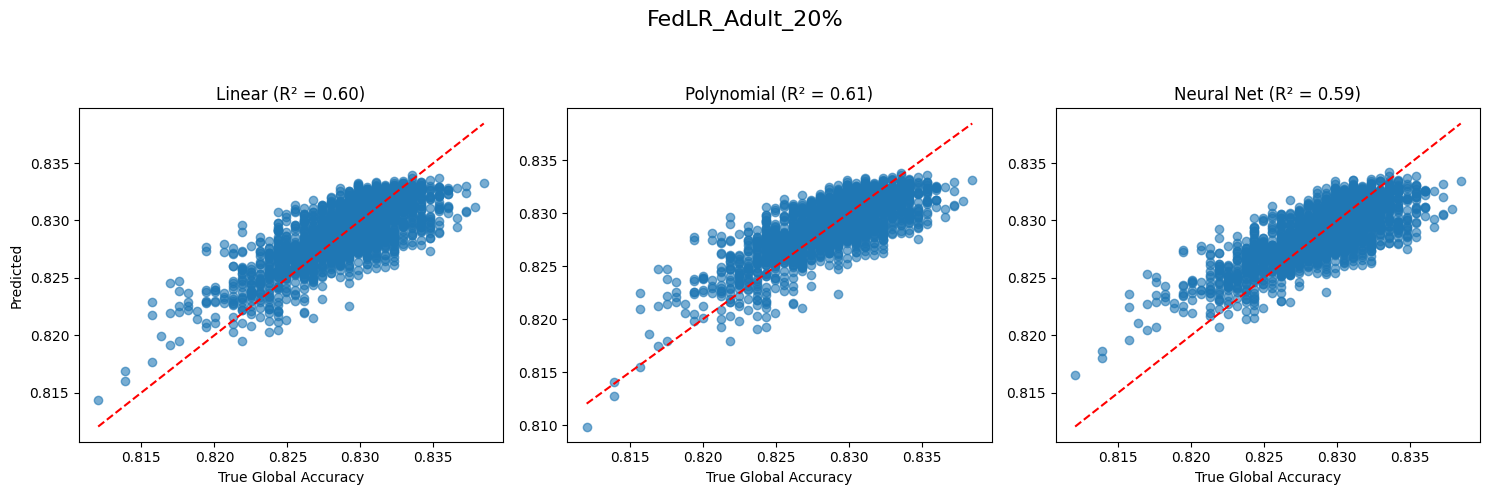

In [43]:
plot_model_predictions(
    y,
    results['linear']['y_pred'],
    results['polynomial']['y_pred'],
    results['neural_net']['y_pred'],
    results['linear']['r2'],
    results['polynomial']['r2'],
    results['neural_net']['r2'],
    title="FedLR_Adult_20%"
)

In [ ]:
#print(markdown_equations(results))

###  Linear Model 

$$
A_g = 0.9143 \cdot \mu + 0.4953 \cdot \sigma + 0.0718
$$

---

###  Polynomial Model 

$$
A_g =  - (23.0822 \cdot \mu^2 +  2.0264 \cdot \sigma^2 ) + 39.0976 \cdot \mu + 23.7383 \cdot \sigma + -28.2702 \cdot \mu \cdot \sigma 
$$

### Adult _ FedFor

In [44]:
# Load the CSV
df = pd.read_csv("/Users/abbaszal/Documents/Fit/adult_fedfor/adult_20_FedFor_results.csv") 
df[["mu", "sigma"]] = df.apply(compute_mu_sigma, axis=1)
df_train = df[df["Trial"] == 1]
X = df_train[["mu", "sigma"]].values
y = df_train["Global Accuracy"].values

In [45]:
results = evaluate_models(X, y, poly_degree=2, nn_hidden_layer_sizes=(10,), nn_max_iter=10000)

Linear Model:
  A_g = 0.3098 * mu + 1.0838 * sigma + 0.5791
  R² Score: 0.3994

Polynomial Model (Degree 2):
  30.0518 * mu
  11.5250 * sigma
  -18.1307 * mu^2
  -9.0277 * mu sigma
  -179.6112 * sigma^2
  R² Score: 0.5059

Neural Network Model:
  Hidden layers: (10,), max_iter: 10000
  R² Score: 0.2710



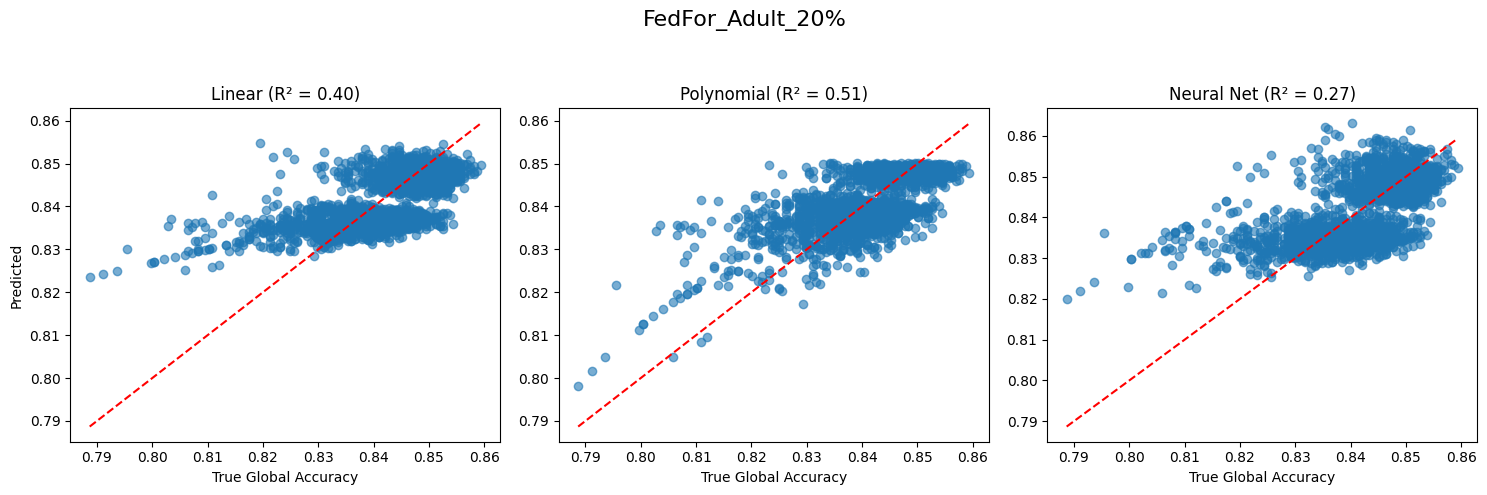

In [46]:
plot_model_predictions(
    y,
    results['linear']['y_pred'],
    results['polynomial']['y_pred'],
    results['neural_net']['y_pred'],
    results['linear']['r2'],
    results['polynomial']['r2'],
    results['neural_net']['r2'],
    title="FedFor_Adult_20%"
)

In [ ]:
#print(markdown_equations(results))

###  Linear Model 

$$
A_g = 0.3098 \cdot \mu + 1.0838 \cdot \sigma + 0.5791
$$

---

###  Polynomial Model 

$$
A_g =  - (18.1307 \cdot \mu^2 +  179.6112 \cdot \sigma^2 ) + 30.0518 \cdot \mu + 11.5250 \cdot \sigma + -9.0277 \cdot \mu \cdot \sigma 
$$

### Skin _ FedLR

In [ ]:
# Load the CSV
df = pd.read_csv("/Users/abbaszal/Documents/Fit/skin_fedlr/skin_10_LR_results.csv") 
df[["mu", "sigma"]] = df.apply(compute_mu_sigma, axis=1)
df_train = df[df["Trial"] == 1]
X = df_train[["mu", "sigma"]].values
y = df_train["Global Accuracy"].values

In [49]:
results = evaluate_models(X, y, poly_degree=2, nn_hidden_layer_sizes=(10,), nn_max_iter=10000)

Linear Model:
  A_g = 0.7121 * mu + 0.0479 * sigma + 0.2644
  R² Score: 0.6872

Polynomial Model (Degree 2):
  -51.6484 * mu
  92.4544 * sigma
  28.5977 * mu^2
  -100.6237 * mu sigma
  25.9391 * sigma^2
  R² Score: 0.7116

Neural Network Model:
  Hidden layers: (10,), max_iter: 10000
  R² Score: 0.6130



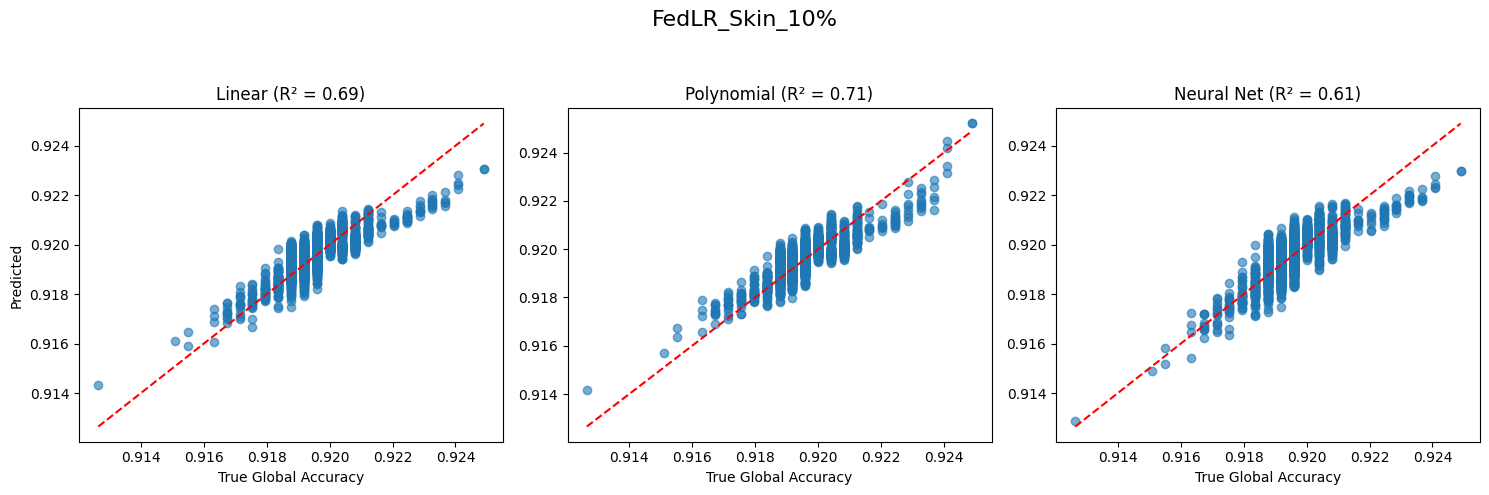

In [50]:
plot_model_predictions(
    y,
    results['linear']['y_pred'],
    results['polynomial']['y_pred'],
    results['neural_net']['y_pred'],
    results['linear']['r2'],
    results['polynomial']['r2'],
    results['neural_net']['r2'],
    title="FedLR_Skin_10%"
)

In [ ]:
#print(markdown_equations(results))

###  Linear Model 

$$
A_g = 0.7121 \cdot \mu + 0.0479 \cdot \sigma + 0.2644
$$

---

###  Polynomial Model 

$$
A_g =  - (28.5977 \cdot \mu^2 +  25.9391 \cdot \sigma^2 ) + -51.6484 \cdot \mu + 92.4544 \cdot \sigma + -100.6237 \cdot \mu \cdot \sigma 
$$

### Skin _ FedFor

In [53]:
# Load the CSV
df = pd.read_csv("/Users/abbaszal/Documents/Fit/skin_fedfor/skin_10_FedFor_results.csv") 
df[["mu", "sigma"]] = df.apply(compute_mu_sigma, axis=1)
df_train = df[df["Trial"] == 1]
X = df_train[["mu", "sigma"]].values
y = df_train["Global Accuracy"].values

In [54]:
results = evaluate_models(X, y, poly_degree=2, nn_hidden_layer_sizes=(10,), nn_max_iter=10000)

Linear Model:
  A_g = 0.6957 * mu + 1.2967 * sigma + 0.3031
  R² Score: 0.3776

Polynomial Model (Degree 2):
  -91.9680 * mu
  129.7846 * sigma
  46.7938 * mu^2
  -127.8864 * mu sigma
  -546.8537 * sigma^2
  R² Score: 0.4077

Neural Network Model:
  Hidden layers: (10,), max_iter: 10000
  R² Score: 0.0765



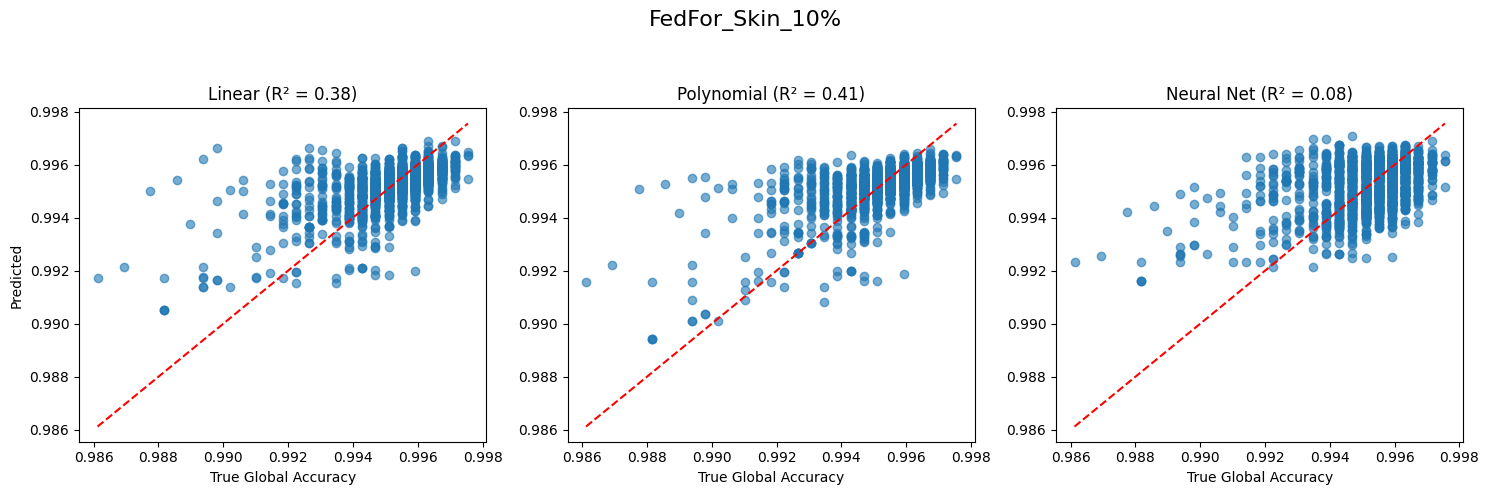

In [55]:
plot_model_predictions(
    y,
    results['linear']['y_pred'],
    results['polynomial']['y_pred'],
    results['neural_net']['y_pred'],
    results['linear']['r2'],
    results['polynomial']['r2'],
    results['neural_net']['r2'],
    title="FedFor_Skin_10%"
)

In [ ]:
#print(markdown_equations(results))

###  Linear Model 

$$
A_g = 0.6957 \cdot \mu + 1.2967 \cdot \sigma + 0.3031
$$

---

###  Polynomial Model 

$$
A_g =  - (46.7938 \cdot \mu^2 +  546.8537 \cdot \sigma^2 ) + -91.9680 \cdot \mu + 129.7846 \cdot \sigma + -127.8864 \cdot \mu \cdot \sigma 
$$

In [ ]:
results = evaluate_models(X, y, poly_degree=2, nn_hidden_layer_sizes=(10,), nn_max_iter=10000)
plot_model_predictions(
    y,
    results['linear']['y_pred'],
    results['polynomial']['y_pred'],
    results['neural_net']['y_pred'],
    results['linear']['r2'],
    results['polynomial']['r2'],
    results['neural_net']['r2'],
    title="FedLR_HuGaDB"
)
print(markdown_equations(results))

In [ ]:
df[["mu", "sigma"]] = df.apply(compute_mu_sigma, axis=1)
X = df[["mu", "sigma"]].values
y = df["Global Accuracy"].values


# Linear Model
linear_model = LinearRegression()
linear_model.fit(X, y)
linear_pred = linear_model.predict(X)
linear_r2 = r2_score(y, linear_pred)
equation_linear = f"A_g = {linear_model.coef_[0]:.4f} * mu + {linear_model.coef_[1]:.4f} * sigma + {linear_model.intercept_:.4f}"
print("Linear Model:")
print(equation_linear)
print(f"R² Score: {linear_r2:.4f}\n")


# Polynomial Model
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X, y)
poly_pred = poly_model.predict(X)
poly_r2 = r2_score(y, poly_pred)

# Print polynomial equation
coefs = poly_model.named_steps["linearregression"].coef_
features = poly_model.named_steps["polynomialfeatures"].get_feature_names_out(["mu", "sigma"])
print("Polynomial Model (Degree 2):")
for feat, coef in zip(features, coefs):
    if coef != 0:
        print(f"{coef:.4f} * {feat}")
print(f"R² Score: {poly_r2:.4f}\n")

# Neural Network Model
nn_model = MLPRegressor(hidden_layer_sizes=(10,), max_iter=10000, random_state=0)
nn_model.fit(X, y)
nn_pred = nn_model.predict(X)
nn_r2 = r2_score(y, nn_pred)
print(f"R² Score: {nn_r2:.4f}\n")


# Plot predictions
plt.figure(figsize=(15, 5))

# Linear
plt.subplot(1, 3, 1)
plt.scatter(y, linear_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("True Global Accuracy")
plt.ylabel("Predicted")
plt.title(f"Linear (R² = {linear_r2:.2f})")

# Polynomial
plt.subplot(1, 3, 2)
plt.scatter(y, poly_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("True Global Accuracy")
plt.title(f"Polynomial (R² = {poly_r2:.2f})")

# Neural Net
plt.subplot(1, 3, 3)
plt.scatter(y, nn_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("True Global Accuracy")
plt.title(f"Neural Net (R² = {nn_r2:.2f})")

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D




# 3) Compute μ and σ for every coalition
df[['mu','sigma']] = df.apply(compute_mu_sigma, axis=1)

# 4) Prepare data for plotting
X = df['mu'].values
Y = df['sigma'].values
Z = df['Global Accuracy'].values

# 5) Plot the 3D scatter
fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    X, Y, Z,
    c=Z,          # color by global accuracy
    cmap='viridis',
    s=40,         # point size
    depthshade=True
)

ax.set_xlabel('Mean local accuracy (μ)',  labelpad=10)
ax.set_ylabel('Std dev of accuracies (σ)', labelpad=10)
ax.set_zlabel('Global accuracy (A_g)',    labelpad=10)
plt.title('3D Scatter: μ, σ vs A_g', pad=20)
plt.colorbar(sc, label='Global Accuracy')

# (Optional) adjust view angle
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()
